In [2]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import (ggplot, 
                      aes,
                      geom_line,
                      theme_bw,
                      geom_histogram,
                      scale_x_log10,
                      scale_x_sqrt)
from plotnine_prism import theme_prism
from collections import namedtuple, defaultdict
import numpy as np
import os
import json
from tqdm.notebook import tqdm
from datetime import datetime
from bisect import bisect_left, bisect_right
%matplotlib inline

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20}, style="white")  

In [3]:
TableConfig = namedtuple("TableConfig", "tname author body utc subforum")

In [4]:
PlotConfig = namedtuple("PlotConfig", "hist_log hist2_log max_hist2")

In [5]:
reddit_config = TableConfig("reddit", "author", "body", "created_utc", "subreddit")
dread_config = TableConfig("dread", "creator_id", "content", "created_on", "board")

In [7]:
def basic_stats(conn: duckdb.DuckDBPyConnection, tconfig: TableConfig, pconfig: PlotConfig):
   #q = duckdb.sql(f"SELECT * FROM {tconfig.tname} LIMIT 1",
   #               connection=conn)    
   #print(q.fetchall())
   ### n_authors
   results = defaultdict(dict)
   n_auth = duckdb.sql(f"SELECT COUNT(*) FROM {tconfig.tname}",
                       connection=conn).fetchone()
   print("Num authors: ", n_auth[0])
   post_counts = duckdb.sql(f"SELECT len({tconfig.utc}) FROM {tconfig.tname}", connection=conn).fetchall()
   post_counts = np.array(post_counts).flatten()
   n_posts = post_counts.sum()
   print("Num Posts: ", n_posts)

   # Posts per author histogram:
   df = pd.DataFrame({"n_post": post_counts})
   fig, ax = plt.subplots()
   plot = sns.ecdfplot(
      data=df, x="n_post", 
      log_scale=pconfig.hist_log,
      ax=ax
   )
   results["dicts"]["n_post_cdf"] = df
   results["plots"]["n_post_cdf"] = (plot, fig, ax)

   subredditwise_counts = duckdb.sql(f"SELECT {tconfig.subforum}, COUNT(*) AS n_posts FROM \
                                      (SELECT UNNEST({tconfig.subforum}) AS {tconfig.subforum} FROM {tconfig.tname}) \
                                       GROUP BY {tconfig.subforum}",
                                     connection=conn).fetchall()
   results["dicts"]["subforum_posts"] = subredditwise_counts   

   total_subreddits = duckdb.sql(f"SELECT COUNT(DISTINCT({tconfig.subforum})) FROM \
                                   (SELECT UNNEST({tconfig.subforum}) AS {tconfig.subforum} FROM {tconfig.tname})", connection=conn).fetchone()
   print("Total subforums: ", total_subreddits[0])

   n_subreddit_per_author = duckdb.sql(f"SELECT {tconfig.author}, list_unique({tconfig.subforum}) FROM {tconfig.tname}", connection=conn).fetchall()
   n_sub_arr = np.array([t[1] for t in n_subreddit_per_author], dtype=np.int32)

   print(f"Authors with n_subforum above thresh (>= {pconfig.max_hist2}): ", 
         [(auth, count) for auth, count in n_subreddit_per_author if count >= pconfig.max_hist2])
   plot_subforums = n_sub_arr[n_sub_arr < pconfig.max_hist2]
   df = pd.DataFrame({"n_subforum": plot_subforums})
   fig, ax = plt.subplots()
   plot_2 = sns.histplot(
      data=df, x="n_subforum",
      discrete=True,
      log_scale=pconfig.hist2_log,
      ax=ax
   )
   results["plots"]["n_subforums"] = (plot_2, fig, ax)
   results["dicts"]["n_subforums"] = df

   return results

In [8]:
all_outputs = {}

***

## Dread

Num authors:  43629
Num Posts:  294596
Total subforums:  382
Authors with n_subforum above thresh (>= 50):  [(22, 77), (377, 50), (400, 66), (388, 62), (37, 139), (5805, 72), (329, 52), (602, 60), (2103, 55)]


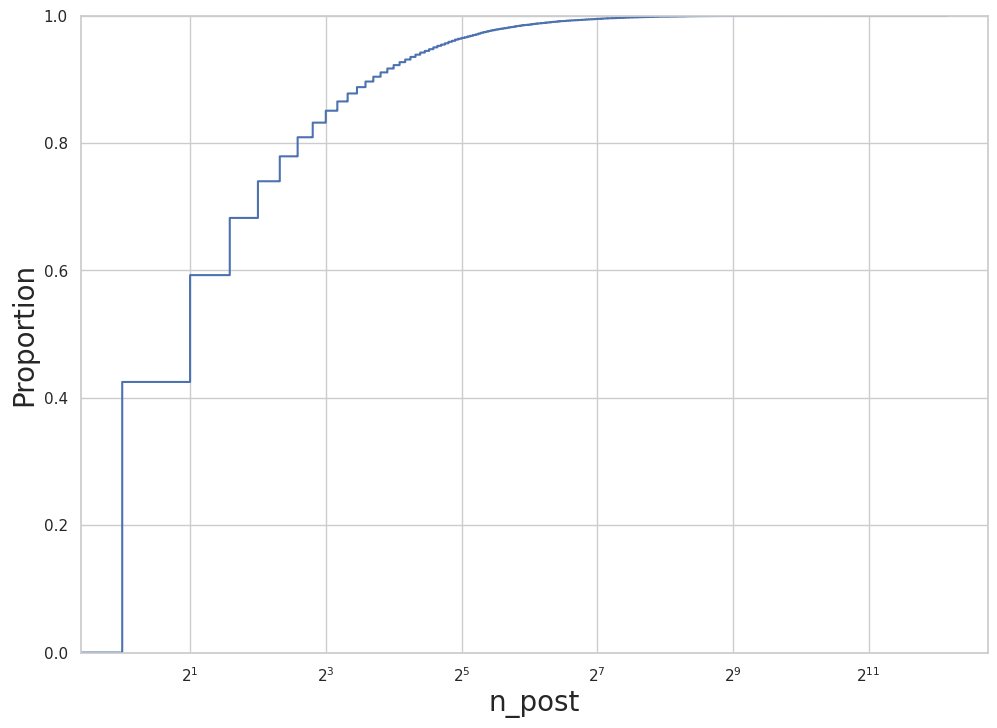

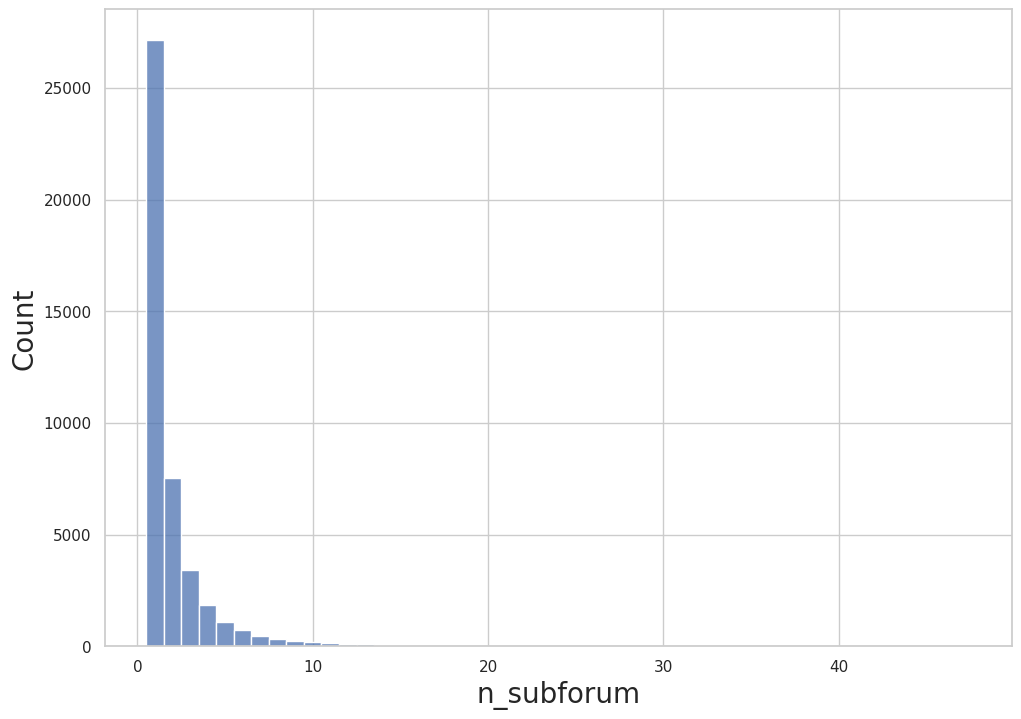

In [9]:
table = duckdb.read_json("/data/ccc/data/dread_all.jsonl")
conn = duckdb.register("dread", table)
plot_config = PlotConfig(2, False, 50)
outputs = basic_stats(conn, dread_config, plot_config)
all_outputs["dread"] = outputs

***
## The Hub

Num authors:  8243
Num Posts:  88753


Total subforums:  62
Authors with n_subforum above thresh (>= 30):  [(2, 32), (1076, 32), (7, 30), (6447, 36), (34428, 36), (34544, 30), (58382, 31), (-1, 42)]


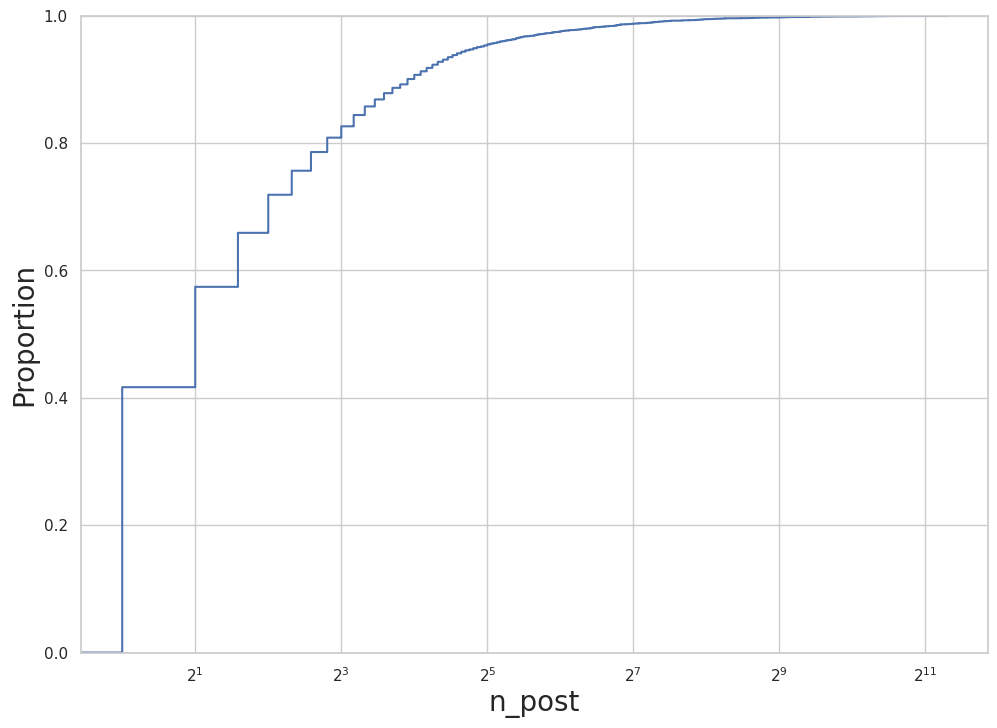

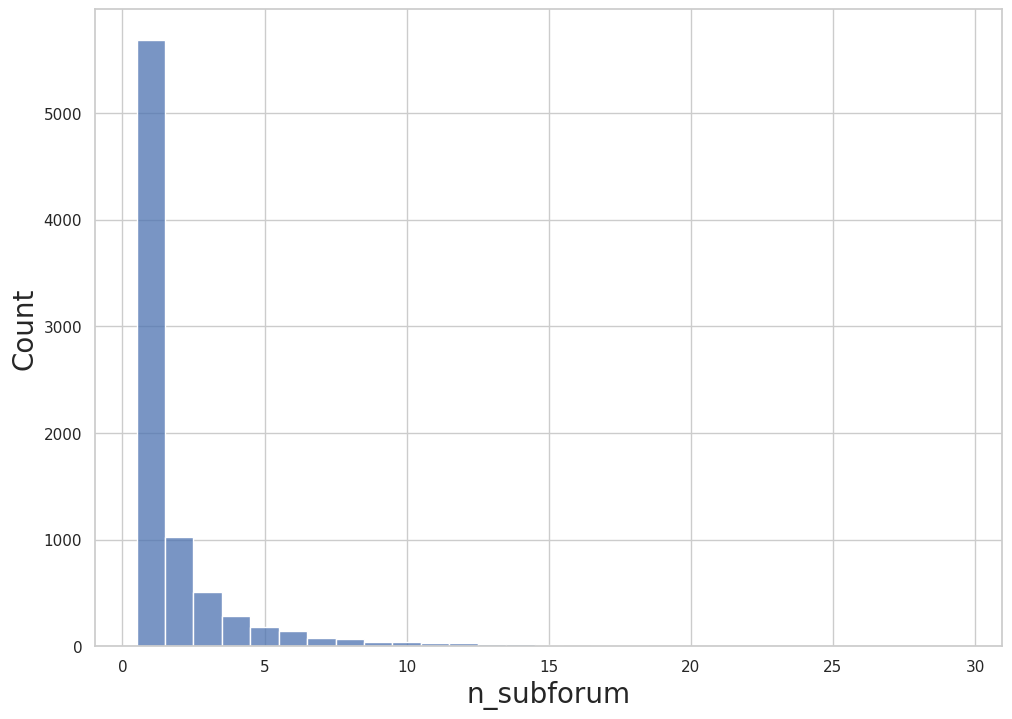

In [10]:
table = duckdb.read_json("/data/ccc/data/thehub_all.jsonl")
conn = duckdb.register("dread", table)
plot_config = PlotConfig(2, False, 30)
outputs = basic_stats(conn, dread_config, plot_config)
all_outputs["thehub"] = outputs

***
## Reddit 2018 Jan

Num authors:  4413757
Num Posts:  82531775


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total subforums:  94945


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Authors with n_subforum above thresh (>= 100):  [('kjm1123490', 101), ('mobitz1', 120), ('congelar', 106), ('joe579003', 103), ('Idontstandout', 109), ('kurisu7885', 127), ('Melechdaviid', 142), ('MegaAlex', 114), ('KennethMcCarthy', 129), ('ErikaLight', 122), ('PokWangpanmang', 115), ('knowses', 103), ('SirLotsaLocks', 105), ('KaribouLouDied', 111), ('concretepigeon', 119), ('Alias-_-Me', 107), ('gazongas001', 256), ('MrsBoombastic98', 157), ('heykevo', 139), ('ThatOtherGuy_CA', 140), ('CreamyGoodnss', 120), ('DigThatFunk', 103), ('MeatloafPopsicle', 101), ('shit_poster9000', 109), ('4__20', 186), ('advertentlyvertical', 121), ('NotTheOneYouNeed', 110), ('Rain12913', 102), ('Jake0024', 100), ('weavves', 100), ('AlphaNathan', 100), ('Stompedyourhousewith', 116), ('trxbyx', 107), ('octanemembrane_', 107), ('jerdub1993', 151), ('MyStrangeUncles', 111), ('madd74', 109), ('jppianoguy', 115), ('Murgie', 127), ('IsaacEiland-Hall', 163), ('teuast', 113), ('LouisSeaGays', 108), ('SynisterSilen

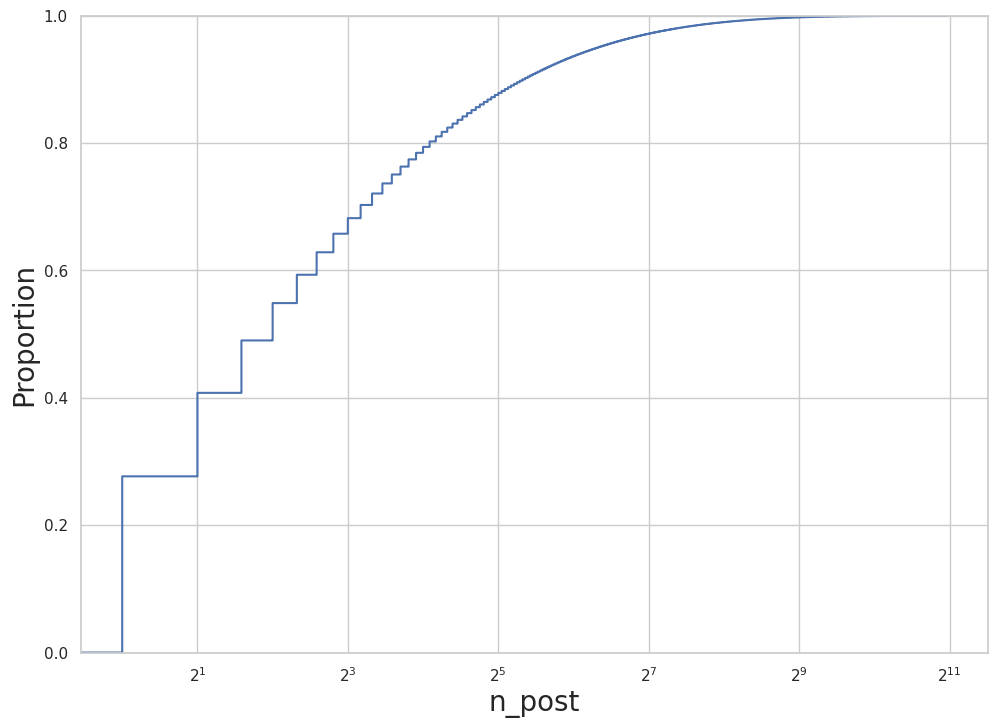

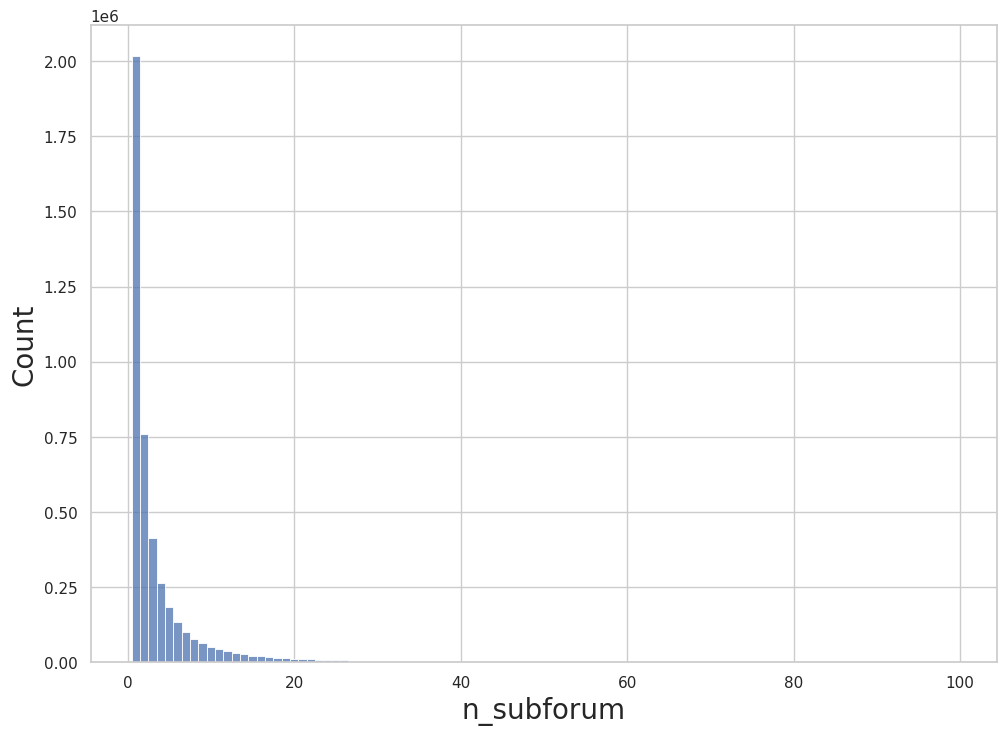

In [12]:
table = duckdb.read_json("/data/ccc/data/reddit_RC_2018_01")
conn = duckdb.register("reddit", table)
plot_config = PlotConfig(2, False, 100)
outputs = basic_stats(conn, reddit_config, plot_config)
all_outputs["reddit_201801"]  = outputs

***
Reddit Dec 2019

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Num authors:  7439040


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Num Posts:  126992546


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total subforums:  155864


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Authors with n_subforum above thresh (>= 100):  [('Gameknight6916', 117), ('r55r44', 105), ('heathmon1856', 104), ('throwlog', 104), ('DarkNite0w0', 106), ('toeofcamell', 136), ('koaasst', 106), ('moschles', 135), ('Reddsrbest', 147), ('Curious9125', 105), ('-toad', 124), ('magik_sx', 103), ('imaginexus', 110), ('labman32', 290), ('trznx', 138), ('jamiedix0n', 102), ('InsidePerformer', 100), ('JuanWithTheDeagle', 107), ('DownshiftedRare', 117), ('Thelema_12', 148), ('JackTheStryker', 100), ('deny_death', 104), ('swyeary', 297), ('Henry_Boyer', 130), ('alnicos', 100), ('marroniugelli', 165), ('bolivar-shagnasty', 102), ('Comrade_Oghma', 102), ('Carson_Keppel', 111), ('QuietRains813', 108), ('MicrOwOave', 142), ('Kalmish', 100), ('jikkler', 103), ('One_Percent_Kid', 111), ('dfinkelstein', 119), ('epicgamer17', 105), ('kb3rry', 132), ('PM_PICS_OF_ME_NAKED', 141), ('AyeAye_Kane', 173), ('WillNewbie', 147), ('IsThatUMoatilliatta', 109), ('HOCK88_', 128), ('NaRa0', 129), ('Zeroch123', 151), 

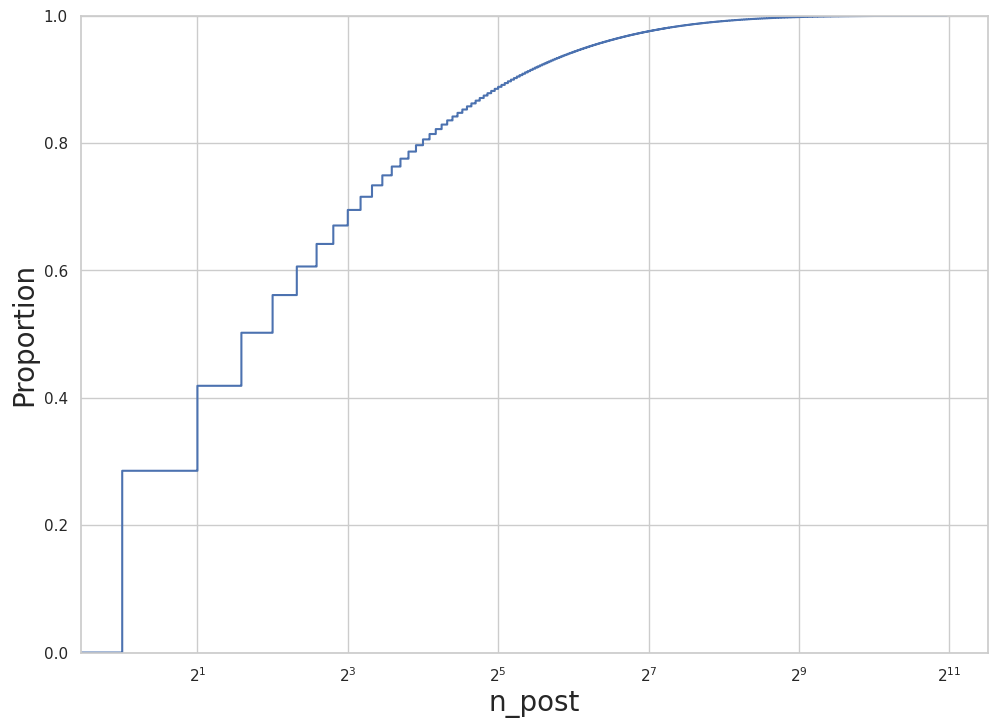

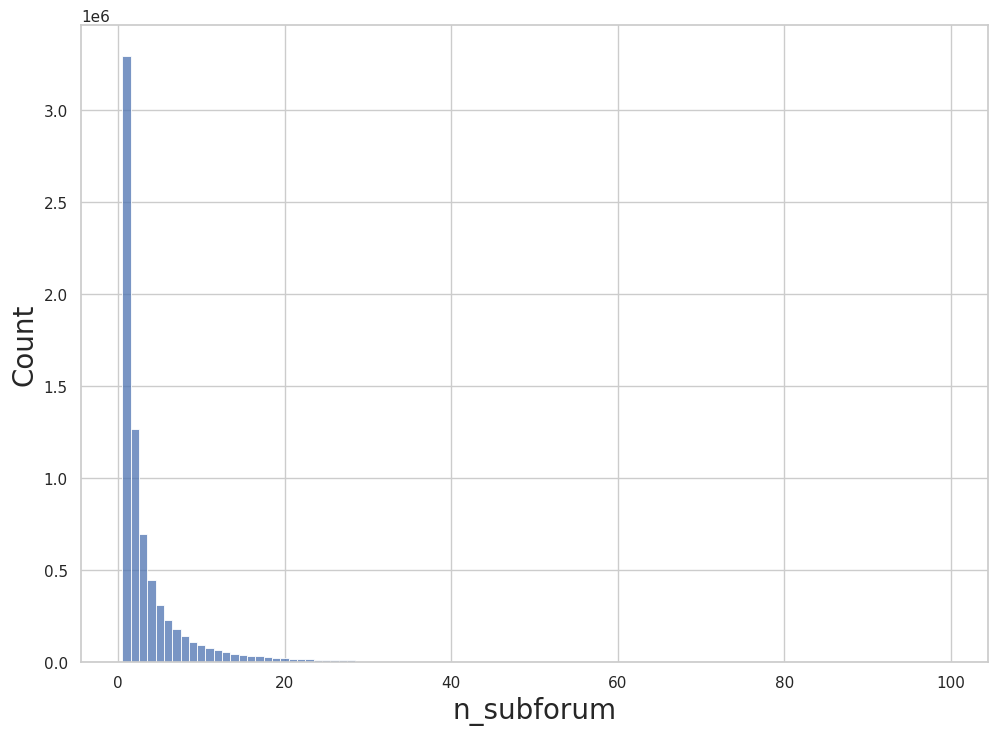

In [15]:
table = duckdb.read_json("/data/ccc/data/reddit_RC_2019_12")
conn = duckdb.register("reddit", table)
plot_config = PlotConfig(2, False, 100)
outputs = basic_stats(conn, reddit_config, plot_config)
all_outputs["reddit_201912"] = outputs

In [17]:
## ecdf n_posts
dfs = []
for key, value in all_outputs.items():
    df = value["dicts"]["n_post_cdf"]
    df["ds"] = key
    dfs.append(df)

plot_df = pd.concat(dfs)

<Axes: xlabel='n_post', ylabel='Proportion'>

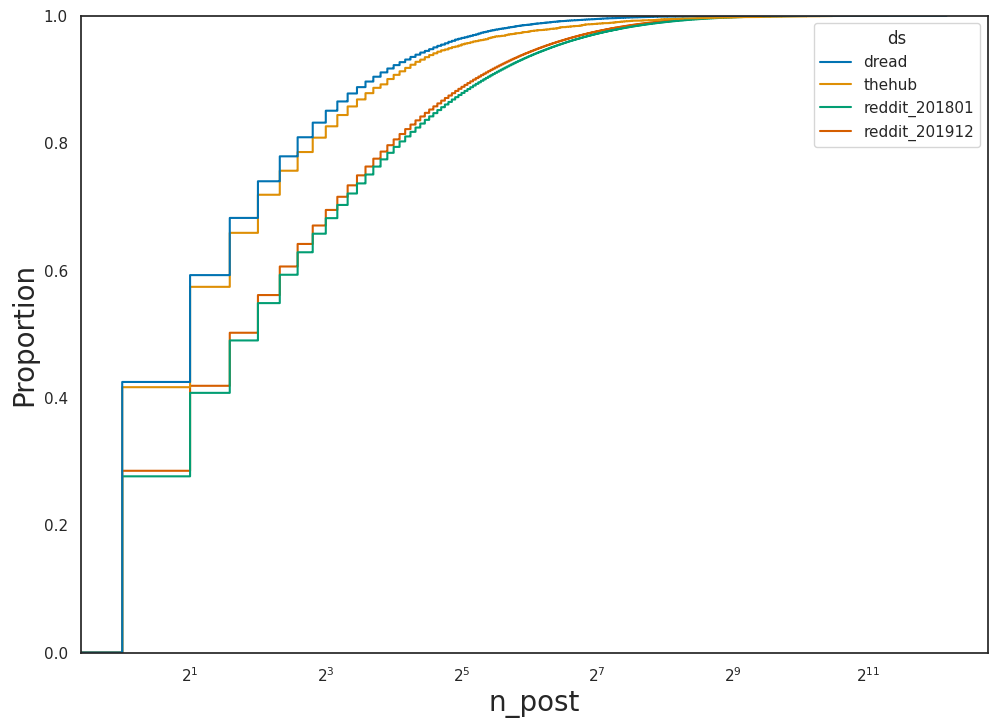

In [22]:
sns.ecdfplot(plot_df, x="n_post", hue="ds", log_scale=2, palette="colorblind")

In [24]:
## ecdf n_subforum
dfs = []
for key, value in all_outputs.items():
    df = value["dicts"]["n_subforums"]
    df["ds"] = key
    dfs.append(df)

plot_df = pd.concat(dfs)

<Axes: xlabel='n_subforum', ylabel='Proportion'>

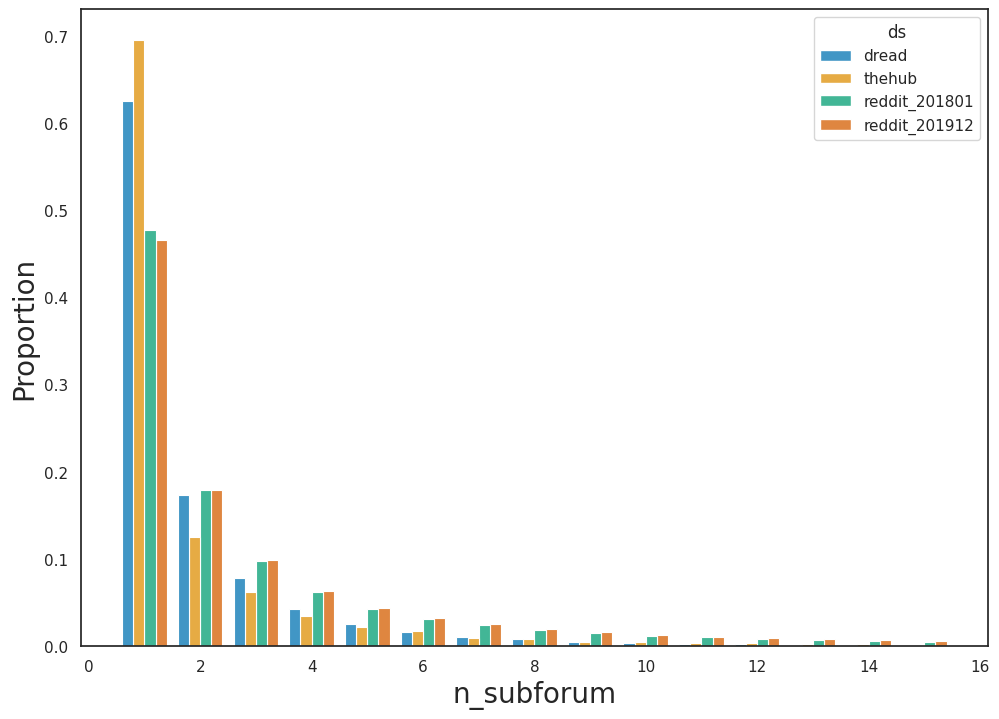

In [37]:
sns.histplot(plot_df[plot_df["n_subforum"] <= 15], x="n_subforum", stat="proportion", hue="ds", common_norm=False, discrete=True, multiple="dodge", palette="colorblind", pthresh=0.1, shrink=0.8)

In [9]:
###
data = []
for ds in ["thehub", "dread", "reddit_2018_sample", "reddit_2019_sample"]:
    df_dir = f"final/{ds}"
    for d in os.listdir(df_dir):
        df = pd.read_json(f"final/{ds}/{d}", orient="records", lines=True)
        n_authors = len(df)
        if "reddit" in ds:
            n_posts = df["body"].apply(len).sum()
        else:
            n_posts = df["content"].apply(len).sum()

        print(ds, d, ",", n_authors, ",", n_posts )
        data.append({"ds": ds, "split": d.split(".")[0], "n_authors": n_authors, "n_posts": n_posts})

thehub train.jsonl , 3072 , 58813
thehub test_queries.jsonl , 1354 , 13456
thehub test_targets.jsonl , 1354 , 14191
dread train.jsonl , 18547 , 232271
dread test_queries.jsonl , 10414 , 84506
dread test_targets.jsonl , 10414 , 90331
reddit_2018_sample train.jsonl , 19822 , 544208
reddit_2018_sample test_queries.jsonl , 12461 , 233398
reddit_2018_sample test_targets.jsonl , 12461 , 240019
reddit_2019_sample train.jsonl , 19699 , 491582
reddit_2019_sample test_queries.jsonl , 11977 , 206704
reddit_2019_sample test_targets.jsonl , 11977 , 213077


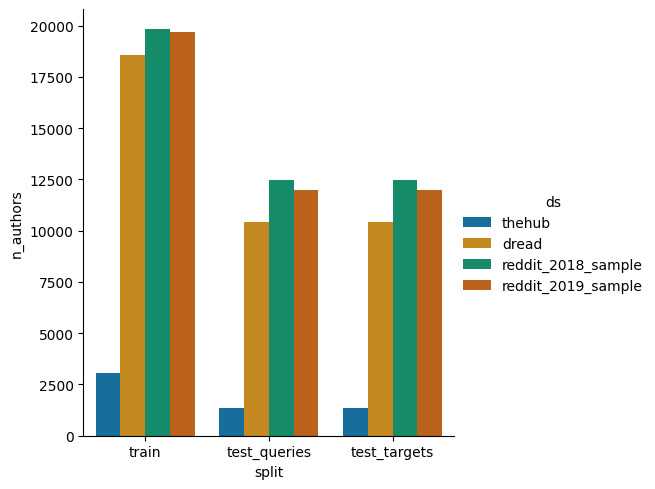

In [11]:
df = pd.DataFrame(data)
sns.catplot(df, kind="bar", x="split", y="n_authors", hue="ds", palette="colorblind")

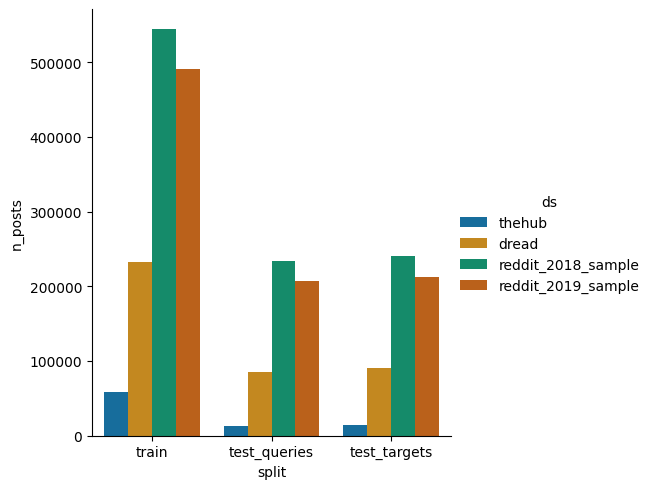

In [12]:
sns.catplot(df, kind="bar", x="split", y="n_posts", hue="ds", palette="colorblind")

In [14]:
m_df = df.melt(id_vars=["ds", "split"], value_vars=["n_posts", "n_authors"])

In [15]:
m_df.columns

Index(['ds', 'split', 'variable', 'value'], dtype='object')

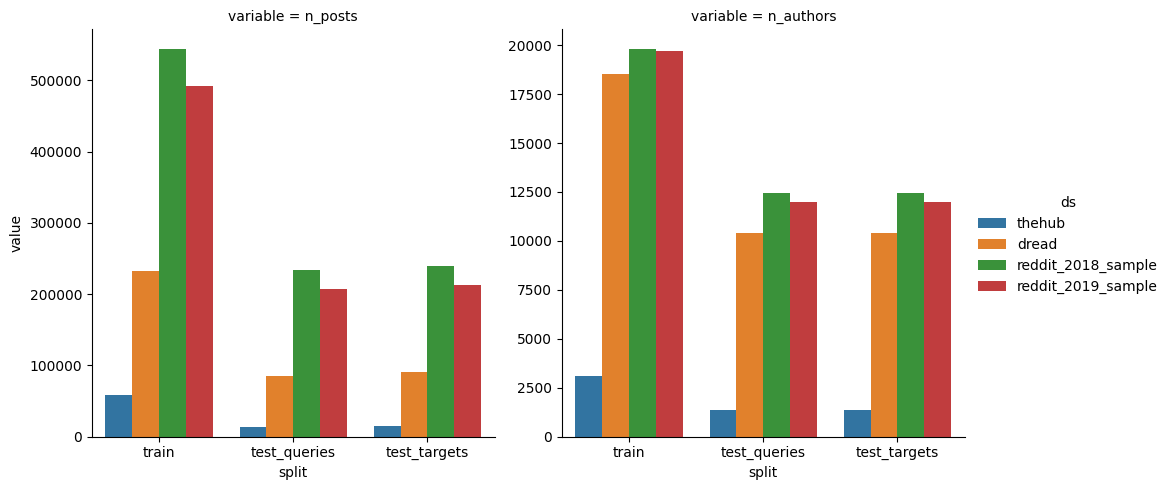

In [19]:
sns.catplot(m_df, kind="bar", x="split", y="value", hue="ds", col="variable", sharey=False)